In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Any
import seaborn as sns

# Set up the path to the detailed generation files
base_path = "../GRPO_based_soft_thinking/output/mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_200_2/training_logs"
vanilla_path = "../GRPO_based_soft_thinking/output/mixture_grpo_mixture_with_k_autostop_1.5b_vanilla_200_2.5b_dirichlet_200_2/training_logs"


def load_detailed_generation(round_num: int) -> Dict[str, Any]:
    """Load a detailed generation JSON file for a specific training round."""
    filepath = os.path.join(base_path, f"{round_num}_detailed_generation.json")
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    else:
        print(f"File not found: {filepath}")
        return None

def analyze_generation_metadata(gen_data: Dict[str, Any]) -> Dict[str, Any]:
    """Extract high-level metadata from generation data."""
    if not gen_data:
        return None
    
    metadata = {
        'num_chains': gen_data.get('num_chains', 0),
        'max_completion_length': gen_data.get('max_completion_length', 0),
        'temperature': gen_data.get('temperature', 0),
        'think_end_token_ids': gen_data.get('think_end_token_ids', []),
        'total_generation_steps': len(gen_data.get('generation_steps', [])),
        'phase_transitions': len(gen_data.get('phase_transitions', [])),
        'final_sequence_lengths': gen_data.get('final_sequences', {}).get('sequence_lengths', [])
    }
    
    return metadata

def analyze_phase_transitions(gen_data: Dict[str, Any]) -> pd.DataFrame:
    """Analyze when chains transitioned from mixture to normal generation."""
    if not gen_data or not gen_data.get('phase_transitions'):
        return pd.DataFrame()
    
    transitions = gen_data['phase_transitions']
    df = pd.DataFrame(transitions)
    return df

def analyze_mixture_behavior(gen_data: Dict[str, Any], max_steps: int = 50) -> Dict[str, Any]:
    """Analyze the mixture behavior in the first few steps."""
    if not gen_data:
        return None
    
    steps = gen_data.get('generation_steps', [])[:max_steps]
    
    mixture_stats = {
        'steps_analyzed': len(steps),
        'chain_mixture_ratios': defaultdict(list),
        'top_k_diversity': [],
        'mixture_weights_entropy': []
    }
    
    for step_data in steps:
        step_num = step_data['step']
        chains = step_data['chains']
        
        # Track diversity of top-k tokens across chains
        all_top_k_tokens = []
        mixture_weights_all_chains = []
        
        for chain in chains:
            if chain.get('is_running') and chain.get('is_mixture_phase'):
                top_k_tokens = chain.get('top_k_token_ids', [])
                mixture_weights = chain.get('normalized_mixture_weights', [])
                
                all_top_k_tokens.extend(top_k_tokens)
                mixture_weights_all_chains.append(mixture_weights)
                
                # Track mixture ratio for this chain
                if len(mixture_weights) >= 2:
                    mixture_stats['chain_mixture_ratios'][chain['chain_id']].append(mixture_weights[1])
        
        # Calculate diversity (unique tokens / total tokens)
        if all_top_k_tokens:
            diversity = len(set(all_top_k_tokens)) / len(all_top_k_tokens)
            mixture_stats['top_k_diversity'].append(diversity)
        
        # Calculate average entropy of mixture weights
        if mixture_weights_all_chains:
            entropies = []
            for weights in mixture_weights_all_chains:
                if len(weights) > 1 and sum(weights) > 0:
                    # Normalize weights
                    weights = np.array(weights)
                    weights = weights / weights.sum()
                    # Calculate entropy
                    entropy = -np.sum(weights * np.log(weights + 1e-10))
                    entropies.append(entropy)
            
            if entropies:
                mixture_stats['mixture_weights_entropy'].append(np.mean(entropies))
    
    return mixture_stats

# Example usage
print("Loading and analyzing detailed generation data...")
print("Available functions:")
print("- load_detailed_generation(round_num)")
print("- analyze_generation_metadata(gen_data)")
print("- analyze_phase_transitions(gen_data)")
print("- analyze_mixture_behavior(gen_data, max_steps)")


Loading and analyzing detailed generation data...
Available functions:
- load_detailed_generation(round_num)
- analyze_generation_metadata(gen_data)
- analyze_phase_transitions(gen_data)
- analyze_mixture_behavior(gen_data, max_steps)


In [2]:
# Example analysis of a specific training round
round_num = 171  # You can change this to analyze different rounds

print(f"Analyzing detailed generation data for round {round_num}...")
gen_data = load_detailed_generation(round_num)

if gen_data:
    # Basic metadata
    metadata = analyze_generation_metadata(gen_data)
    print("\n=== Generation Metadata ===")
    for key, value in metadata.items():
        print(f"{key}: {value}")
    
    # Phase transitions analysis
    print("\n=== Phase Transitions ===")
    transitions_df = analyze_phase_transitions(gen_data)
    if not transitions_df.empty:
        print(f"Number of phase transitions: {len(transitions_df)}")
        print(transitions_df)
    else:
        print("No phase transitions occurred (no </think> tokens found)")
    
    # Mixture behavior analysis
    print("\n=== Mixture Behavior Analysis ===")
    mixture_stats = analyze_mixture_behavior(gen_data, max_steps=20)
    if mixture_stats:
        print(f"Steps analyzed: {mixture_stats['steps_analyzed']}")
        print(f"Average top-k diversity: {np.mean(mixture_stats['top_k_diversity']):.3f}")
        print(f"Average mixture weights entropy: {np.mean(mixture_stats['mixture_weights_entropy']):.3f}")
        
        # Show final generated texts
        print("\n=== Final Generated Responses ===")
        final_texts = gen_data.get('final_sequences', {}).get('decoded_texts', [])
        for i, text in enumerate(final_texts[:3]):  # Show first 3 responses
            print(f"\nChain {i}:")
            print(text[:200] + "..." if len(text) > 200 else text)
else:
    print("Failed to load generation data")


Analyzing detailed generation data for round 171...

=== Generation Metadata ===
num_chains: 16
max_completion_length: 786
temperature: 0.9
think_end_token_ids: [522, 26865, 29]
total_generation_steps: 196
phase_transitions: 0
final_sequence_lengths: [98, 79, 95, 196, 112, 110, 99, 104, 120, 94, 99, 101, 93, 93, 77, 80]

=== Phase Transitions ===
No phase transitions occurred (no </think> tokens found)

=== Mixture Behavior Analysis ===
Steps analyzed: 20
Average top-k diversity: 0.206
Average mixture weights entropy: 0.089

=== Final Generated Responses ===

Chain 0:
<reasoning>
To has 2 trees with 20 plants each, so he has a total of 2 * 20 = 40 plants.
Each plant has 1 seed, so he has 40 seeds.
He plants 60% of the seeds, which is 0.  * 40 = 24 plants.
Therefore...

Chain 1:
<reasoning>
James has 2 trees, each with 20 plants. Therefore, he total number of plants is 2 * 20 = 40 plants.
 He plants 60% of the seeds, so means he plants 0.6 * 40 = 24 plants.
</reasoning>
<answ...

Chain 

Creating visualizations...
=== Comparison Across Training Rounds ===
     avg_diversity  avg_entropy  num_phase_transitions  avg_sequence_length
0         0.204687     0.105447                    0.0             174.9375
1         0.379688     0.127366                    0.0             163.8750
2         0.423438     0.166684                    0.0             177.4375
3         0.445312     0.135786                    0.0             170.0000
4         0.353125     0.124386                    0.0             185.4375
..             ...          ...                    ...                  ...
195       0.215625     0.093616                    0.0             160.1250
196       0.329688     0.125780                    0.0             137.5000
197       0.301563     0.109953                    0.0             211.5000
198       0.281250     0.123785                    0.0             248.1250
199       0.329688     0.120045                    0.0             280.3125

[200 rows x 4 colu

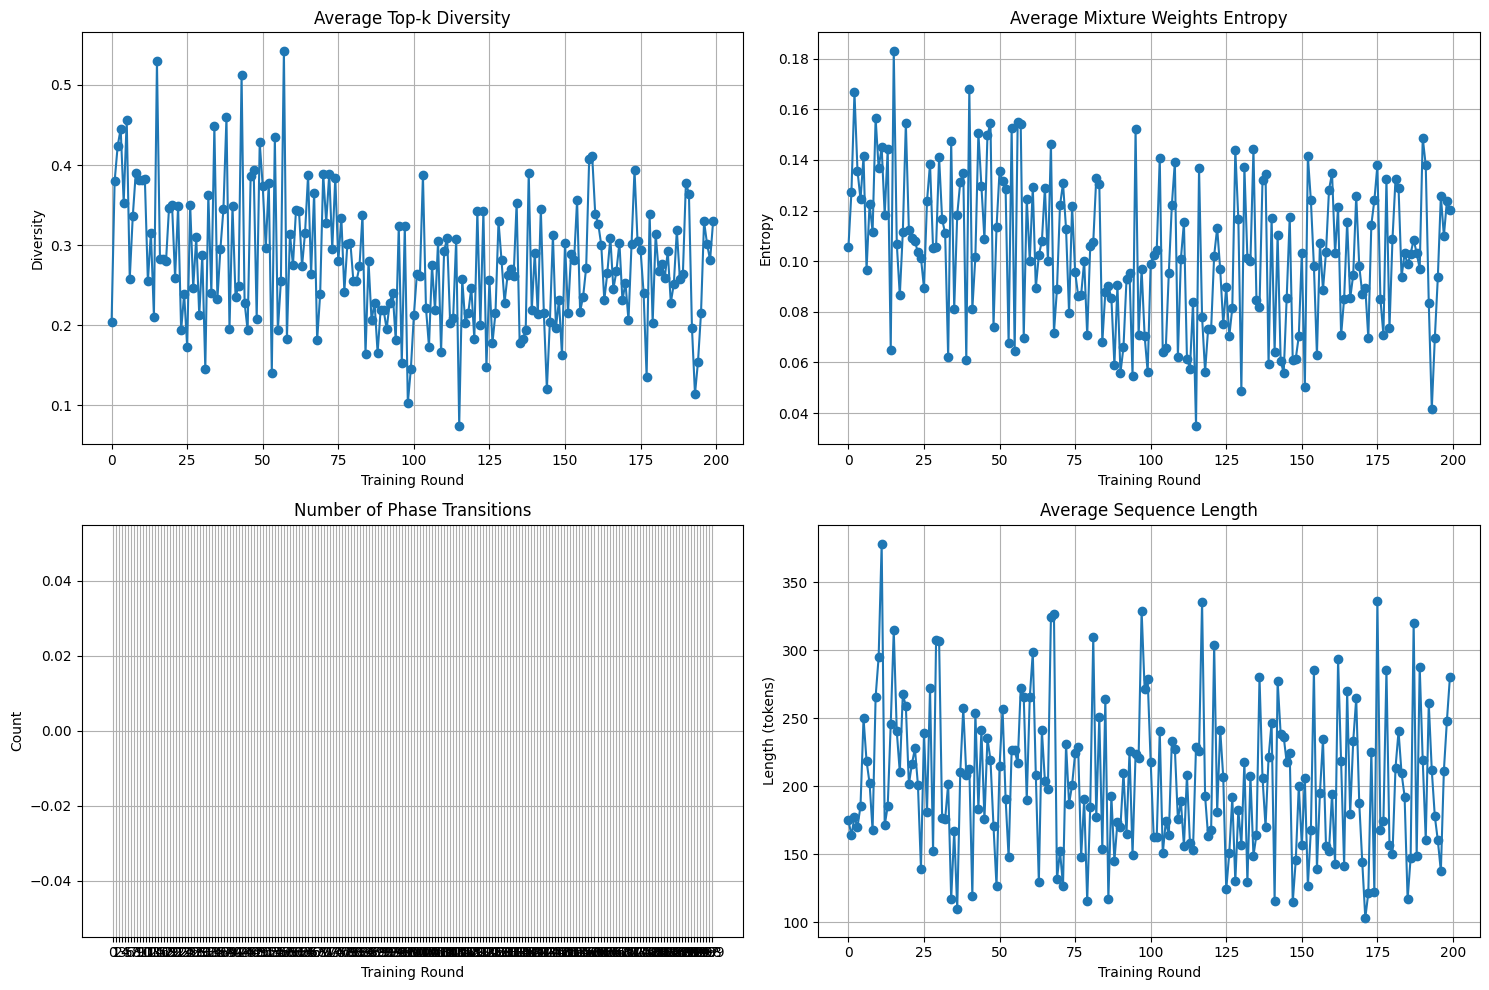

In [3]:
def plot_mixture_behavior(gen_data: Dict[str, Any], max_steps: int = 50):
    """Create visualizations of mixture behavior."""
    mixture_stats = analyze_mixture_behavior(gen_data, max_steps)
    if not mixture_stats:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Top-k diversity over steps
    axes[0, 0].plot(mixture_stats['top_k_diversity'])
    axes[0, 0].set_title('Top-k Token Diversity Over Generation Steps')
    axes[0, 0].set_xlabel('Generation Step')
    axes[0, 0].set_ylabel('Diversity (unique tokens / total tokens)')
    axes[0, 0].grid(True)
    
    # Plot 2: Mixture weights entropy
    axes[0, 1].plot(mixture_stats['mixture_weights_entropy'])
    axes[0, 1].set_title('Mixture Weights Entropy Over Generation Steps')
    axes[0, 1].set_xlabel('Generation Step')
    axes[0, 1].set_ylabel('Average Entropy')
    axes[0, 1].grid(True)
    
    # Plot 3: Final sequence lengths distribution
    final_lengths = gen_data.get('final_sequences', {}).get('sequence_lengths', [])
    if final_lengths:
        axes[1, 0].hist(final_lengths, bins=10, alpha=0.7)
        axes[1, 0].set_title('Distribution of Final Sequence Lengths')
        axes[1, 0].set_xlabel('Sequence Length (tokens)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True)
    
    # Plot 4: Chain mixture ratios (for first few chains)
    chain_ratios = mixture_stats['chain_mixture_ratios']
    for chain_id in list(chain_ratios.keys())[:5]:  # Show first 5 chains
        ratios = chain_ratios[chain_id]
        axes[1, 1].plot(ratios, label=f'Chain {chain_id}', alpha=0.7)
    
    axes[1, 1].set_title('Mixture Ratio (2nd token weight) by Chain')
    axes[1, 1].set_xlabel('Generation Step')
    axes[1, 1].set_ylabel('2nd Token Weight')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def compare_multiple_rounds(round_nums: List[int], max_steps: int = 20):
    """Compare mixture behavior across multiple training rounds."""
    results = {}
    
    for round_num in round_nums:
        gen_data = load_detailed_generation(round_num)
        if gen_data:
            mixture_stats = analyze_mixture_behavior(gen_data, max_steps)
            if mixture_stats:
                results[round_num] = {
                    'avg_diversity': np.mean(mixture_stats['top_k_diversity']),
                    'avg_entropy': np.mean(mixture_stats['mixture_weights_entropy']),
                    'num_phase_transitions': len(gen_data.get('phase_transitions', [])),
                    'avg_sequence_length': np.mean(gen_data.get('final_sequences', {}).get('sequence_lengths', []))
                }
    
    if results:
        df = pd.DataFrame(results).T
        print("=== Comparison Across Training Rounds ===")
        print(df)
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].plot(df.index, df['avg_diversity'], 'o-')
        axes[0, 0].set_title('Average Top-k Diversity')
        axes[0, 0].set_xlabel('Training Round')
        axes[0, 0].set_ylabel('Diversity')
        axes[0, 0].grid(True)
        
        axes[0, 1].plot(df.index, df['avg_entropy'], 'o-')
        axes[0, 1].set_title('Average Mixture Weights Entropy')
        axes[0, 1].set_xlabel('Training Round')
        axes[0, 1].set_ylabel('Entropy')
        axes[0, 1].grid(True)
        
        axes[1, 0].bar(range(len(df)), df['num_phase_transitions'])
        axes[1, 0].set_title('Number of Phase Transitions')
        axes[1, 0].set_xlabel('Training Round')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_xticks(range(len(df)))
        axes[1, 0].set_xticklabels(df.index)
        axes[1, 0].grid(True)
        
        axes[1, 1].plot(df.index, df['avg_sequence_length'], 'o-')
        axes[1, 1].set_title('Average Sequence Length')
        axes[1, 1].set_xlabel('Training Round')
        axes[1, 1].set_ylabel('Length (tokens)')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return df
    else:
        print("No valid data found for the specified rounds")
        return None

# Example visualization
if gen_data:
    print("Creating visualizations...")
    compare_multiple_rounds(range(200))


=== Comparing Multiple Training Rounds ===
=== Comparison Across Training Rounds ===
     avg_diversity  avg_entropy  num_phase_transitions  avg_sequence_length
171       0.206250     0.089418                    0.0             103.1250
175       0.293750     0.137828                    0.0             336.1250
180       0.314063     0.108797                    0.0             150.3125
185       0.228125     0.098835                    0.0             116.8750
190       0.378125     0.148751                    0.0             219.1875
195       0.215625     0.093616                    0.0             160.1250
199       0.329688     0.120045                    0.0             280.3125


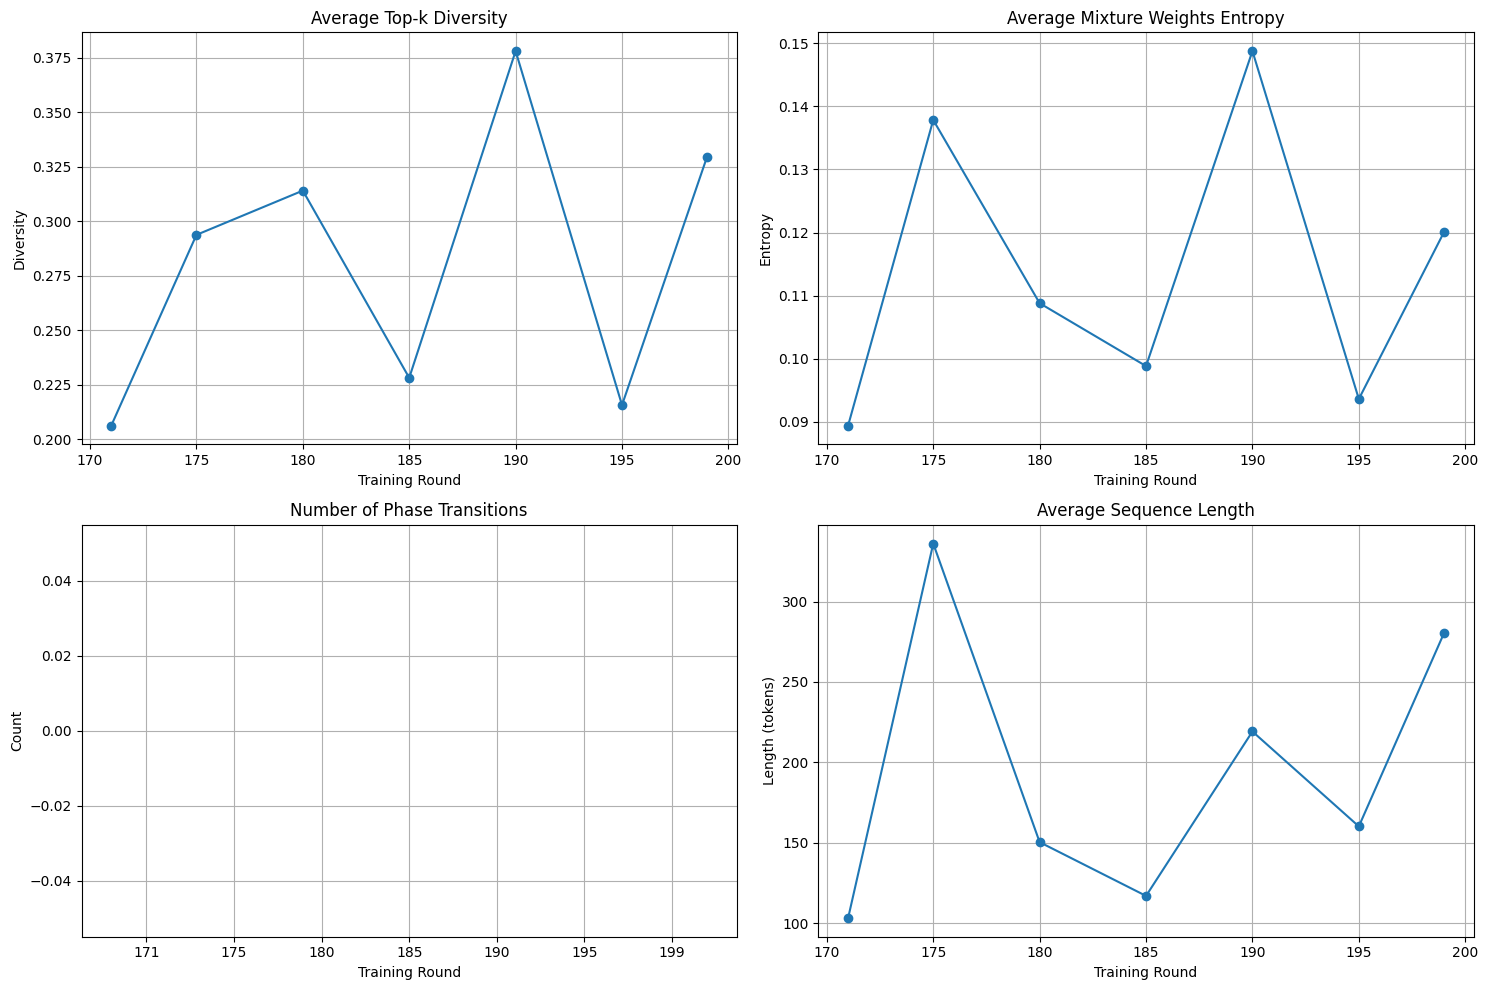


=== Token Selection Patterns ===
Average first token dominance: 0.941
Average token diversity per step: 3.8

=== Dirichlet Sampling Effect ===
Average weight concentration: -72498477084639072.000
Average weight variance: 0.221656

Available training rounds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...


In [4]:
# Compare multiple training rounds
print("=== Comparing Multiple Training Rounds ===")
round_nums = [171, 175, 180, 185, 190, 195, 199]  # You can modify this list
comparison_df = compare_multiple_rounds(round_nums, max_steps=20)

# Additional analysis functions
def analyze_token_selection_patterns(gen_data: Dict[str, Any], max_steps: int = 20):
    """Analyze patterns in token selection during mixture phase."""
    if not gen_data:
        return None
    
    steps = gen_data.get('generation_steps', [])[:max_steps]
    
    token_patterns = {
        'first_token_dominance': [],  # How often the first (highest prob) token is selected
        'token_diversity_per_step': [],  # Number of unique tokens selected across chains
        'mixture_vs_representative': []  # Comparison between mixture and representative selection
    }
    
    for step_data in steps:
        chains = step_data['chains']
        
        first_token_selections = 0
        total_selections = 0
        selected_tokens = []
        
        for chain in chains:
            if chain.get('is_running') and chain.get('is_mixture_phase'):
                selected_token = chain.get('selected_token_id')
                top_k_tokens = chain.get('top_k_token_ids', [])
                representative_idx = chain.get('representative_idx', 0)
                
                if selected_token is not None and top_k_tokens:
                    selected_tokens.append(selected_token)
                    total_selections += 1
                    
                    # Check if first token (highest probability) was selected
                    if representative_idx == 0:
                        first_token_selections += 1
        
        if total_selections > 0:
            token_patterns['first_token_dominance'].append(first_token_selections / total_selections)
            token_patterns['token_diversity_per_step'].append(len(set(selected_tokens)))
    
    return token_patterns

def get_available_rounds():
    """Get list of available training rounds."""
    if not os.path.exists(base_path):
        return []
    
    files = os.listdir(base_path)
    rounds = []
    
    for file in files:
        if file.endswith('_detailed_generation.json'):
            try:
                round_num = int(file.split('_')[0])
                rounds.append(round_num)
            except ValueError:
                continue
    
    return sorted(rounds)

def analyze_dirichlet_effect(gen_data: Dict[str, Any], max_steps: int = 20):
    """Analyze the effect of Dirichlet sampling on mixture weights."""
    if not gen_data:
        return None
    
    steps = gen_data.get('generation_steps', [])[:max_steps]
    
    dirichlet_stats = {
        'original_vs_normalized': [],  # Compare top-k probs vs normalized mixture weights
        'weight_concentration': [],   # How concentrated the weights are
        'weight_variance': []         # Variance in weights across tokens
    }
    
    for step_data in steps:
        chains = step_data['chains']
        
        for chain in chains:
            if chain.get('is_running') and chain.get('is_mixture_phase'):
                top_k_probs = chain.get('top_k_probs', [])
                mixture_weights = chain.get('normalized_mixture_weights', [])
                
                if len(top_k_probs) >= 2 and len(mixture_weights) >= 2:
                    # Compare original probabilities with Dirichlet-sampled weights
                    prob_ratio = top_k_probs[1] / top_k_probs[0] if top_k_probs[0] > 0 else 0
                    weight_ratio = mixture_weights[1] / mixture_weights[0] if mixture_weights[0] > 0 else 0
                    
                    dirichlet_stats['original_vs_normalized'].append({
                        'prob_ratio': prob_ratio,
                        'weight_ratio': weight_ratio,
                        'step': step_data['step']
                    })
                    
                    # Calculate concentration (inverse of entropy)
                    weights = np.array(mixture_weights)
                    if weights.sum() > 0:
                        weights = weights / weights.sum()
                        entropy = -np.sum(weights * np.log(weights + 1e-10))
                        concentration = 1 / (entropy + 1e-10)
                        dirichlet_stats['weight_concentration'].append(concentration)
                        dirichlet_stats['weight_variance'].append(np.var(weights))
    
    return dirichlet_stats

# Example detailed analysis
print("\n=== Token Selection Patterns ===")
if gen_data:
    token_patterns = analyze_token_selection_patterns(gen_data, max_steps=20)
    if token_patterns:
        print(f"Average first token dominance: {np.mean(token_patterns['first_token_dominance']):.3f}")
        print(f"Average token diversity per step: {np.mean(token_patterns['token_diversity_per_step']):.1f}")
    
    print("\n=== Dirichlet Sampling Effect ===")
    dirichlet_stats = analyze_dirichlet_effect(gen_data, max_steps=20)
    if dirichlet_stats:
        print(f"Average weight concentration: {np.mean(dirichlet_stats['weight_concentration']):.3f}")
        print(f"Average weight variance: {np.mean(dirichlet_stats['weight_variance']):.6f}")

print(f"\nAvailable training rounds: {get_available_rounds()[:10]}...")  # Show first 10


=== Cross-Experiment Comparison ===
Loading Dirichlet k=2...
Loading Dirichlet k=4...
File not found: ../GRPO_based_soft_thinking/output/mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_4/training_logs/180_detailed_generation.json
Loading Dirichlet k=8...
Loading Nucleus k=2...
Loading Nucleus k=8...
Loading Element-wise Max k=2...
Loading Vanilla...
File not found: ../GRPO_based_soft_thinking/output/mixture_grpo_mixture_with_k_autostop_1.5b_vanilla_200_2/training_logs/180_detailed_generation.json

=== Experiment Comparison (Round 180) ===
                      avg_diversity  avg_entropy  num_phase_transitions  \
Dirichlet k=2                0.3141       0.1088                    0.0   
Dirichlet k=8                0.2789       0.1335                    0.0   
Nucleus k=2                  0.0625       0.0281                    0.0   
Nucleus k=8                  0.0625       0.4719                    0.0   
Element-wise Max k=2         0.0625       0.4538                    0.0   



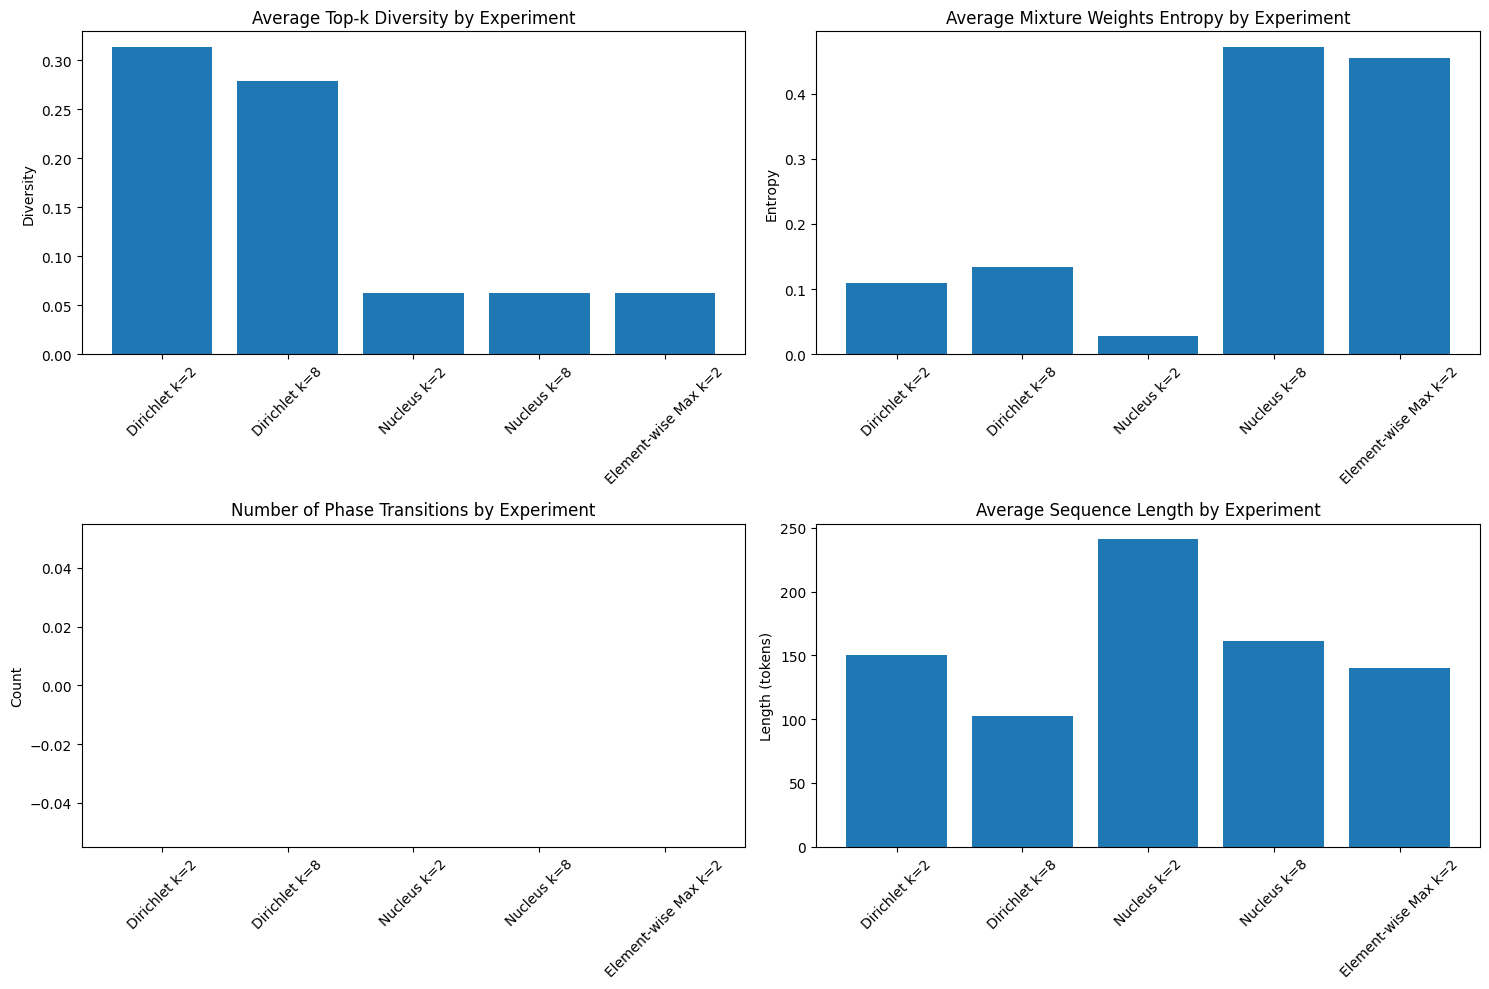


=== Key Insights ===
1. Compare diversity and entropy across different mixture methods
2. Look at phase transitions - do some methods trigger </think> more often?
3. Examine sequence lengths - are some methods more concise?
4. Dirichlet vs Nucleus vs Element-wise Max comparison

You can modify the experiments_to_compare dictionary to analyze different combinations!

All available experiments: ['mixture_grpo_mixture_with_k_autostop_1.5b_1', 'mixture_grpo_mixture_with_k_autostop_1.5b_16', 'mixture_grpo_mixture_with_k_autostop_1.5b_2', 'mixture_grpo_mixture_with_k_autostop_1.5b_4', 'mixture_grpo_mixture_with_k_autostop_1.5b_8', 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_2', 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_200_2', 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_4', 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_8', 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_uniform_4', 'mixture_grpo_mixture_with_k_autostop_1.5b_element_wise_max_2', 'mixt

In [5]:
# Cross-experiment comparison
def load_experiment_data(experiment_name: str, round_num: int):
    """Load detailed generation data from a specific experiment."""
    exp_path = f"../GRPO_based_soft_thinking/output/{experiment_name}/training_logs"
    filepath = os.path.join(exp_path, f"{round_num}_detailed_generation.json")
    
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    else:
        print(f"File not found: {filepath}")
        return None

def compare_experiments(experiments: Dict[str, str], round_num: int = 180, max_steps: int = 20):
    """Compare mixture behavior across different experiments."""
    results = {}
    
    for exp_label, exp_name in experiments.items():
        print(f"Loading {exp_label}...")
        gen_data = load_experiment_data(exp_name, round_num)
        
        if gen_data:
            mixture_stats = analyze_mixture_behavior(gen_data, max_steps)
            if mixture_stats:
                results[exp_label] = {
                    'avg_diversity': np.mean(mixture_stats['top_k_diversity']) if mixture_stats['top_k_diversity'] else 0,
                    'avg_entropy': np.mean(mixture_stats['mixture_weights_entropy']) if mixture_stats['mixture_weights_entropy'] else 0,
                    'num_phase_transitions': len(gen_data.get('phase_transitions', [])),
                    'avg_sequence_length': np.mean(gen_data.get('final_sequences', {}).get('sequence_lengths', [0])),
                    'num_chains': gen_data.get('num_chains', 0),
                    'temperature': gen_data.get('temperature', 0)
                }
    
    if results:
        df = pd.DataFrame(results).T
        print(f"\n=== Experiment Comparison (Round {round_num}) ===")
        print(df.round(4))
        
        # Create comparison visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        experiments_list = list(results.keys())
        
        # Plot comparisons
        axes[0, 0].bar(experiments_list, [results[exp]['avg_diversity'] for exp in experiments_list])
        axes[0, 0].set_title('Average Top-k Diversity by Experiment')
        axes[0, 0].set_ylabel('Diversity')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        axes[0, 1].bar(experiments_list, [results[exp]['avg_entropy'] for exp in experiments_list])
        axes[0, 1].set_title('Average Mixture Weights Entropy by Experiment')
        axes[0, 1].set_ylabel('Entropy')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        axes[1, 0].bar(experiments_list, [results[exp]['num_phase_transitions'] for exp in experiments_list])
        axes[1, 0].set_title('Number of Phase Transitions by Experiment')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        axes[1, 1].bar(experiments_list, [results[exp]['avg_sequence_length'] for exp in experiments_list])
        axes[1, 1].set_title('Average Sequence Length by Experiment')
        axes[1, 1].set_ylabel('Length (tokens)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return df
    else:
        print("No valid data found for comparison")
        return None

# Define experiments to compare - you can modify this dictionary
experiments_to_compare = {
    'Dirichlet k=2': 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_200_2',
    'Dirichlet k=4': 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_4',
    'Dirichlet k=8': 'mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_8',
    'Nucleus k=2': 'mixture_grpo_mixture_with_k_autostop_1.5b_nucleus_2',
    'Nucleus k=8': 'mixture_grpo_mixture_with_k_autostop_1.5b_nucleus_8',
    'Element-wise Max k=2': 'mixture_grpo_mixture_with_k_autostop_1.5b_element_wise_max_2',
    'Vanilla': 'mixture_grpo_mixture_with_k_autostop_1.5b_vanilla_200_2'
}

print("=== Cross-Experiment Comparison ===")
comparison_df = compare_experiments(experiments_to_compare, round_num=180, max_steps=20)

# Summary insights
print("\n=== Key Insights ===")
print("1. Compare diversity and entropy across different mixture methods")
print("2. Look at phase transitions - do some methods trigger </think> more often?")
print("3. Examine sequence lengths - are some methods more concise?")
print("4. Dirichlet vs Nucleus vs Element-wise Max comparison")
print("\nYou can modify the experiments_to_compare dictionary to analyze different combinations!")

# Function to get all available experiments
def get_available_experiments():
    """Get list of all available experiment directories."""
    output_dir = "../GRPO_based_soft_thinking/output"
    if not os.path.exists(output_dir):
        return []
    
    experiments = []
    for item in os.listdir(output_dir):
        if os.path.isdir(os.path.join(output_dir, item)):
            experiments.append(item)
    
    return sorted(experiments)

print(f"\nAll available experiments: {get_available_experiments()}")


/mnt/home/adit/mixtureoftokens/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== ANALYZING VANILLA GENERATION EXPERIMENT ===
Experiment: mixture_grpo_mixture_with_k_autostop_1.5b_vanilla_200_2
Analyzing rounds: [19, 39, 59, 79, 99, 119, 139, 159, 179, 199]
Analyzing round 19...
Analyzing round 39...
Analyzing round 59...
Analyzing round 79...
Analyzing round 99...
Analyzing round 119...
Analyzing round 139...
Analyzing round 159...
Analyzing round 179...
Analyzing round 199...


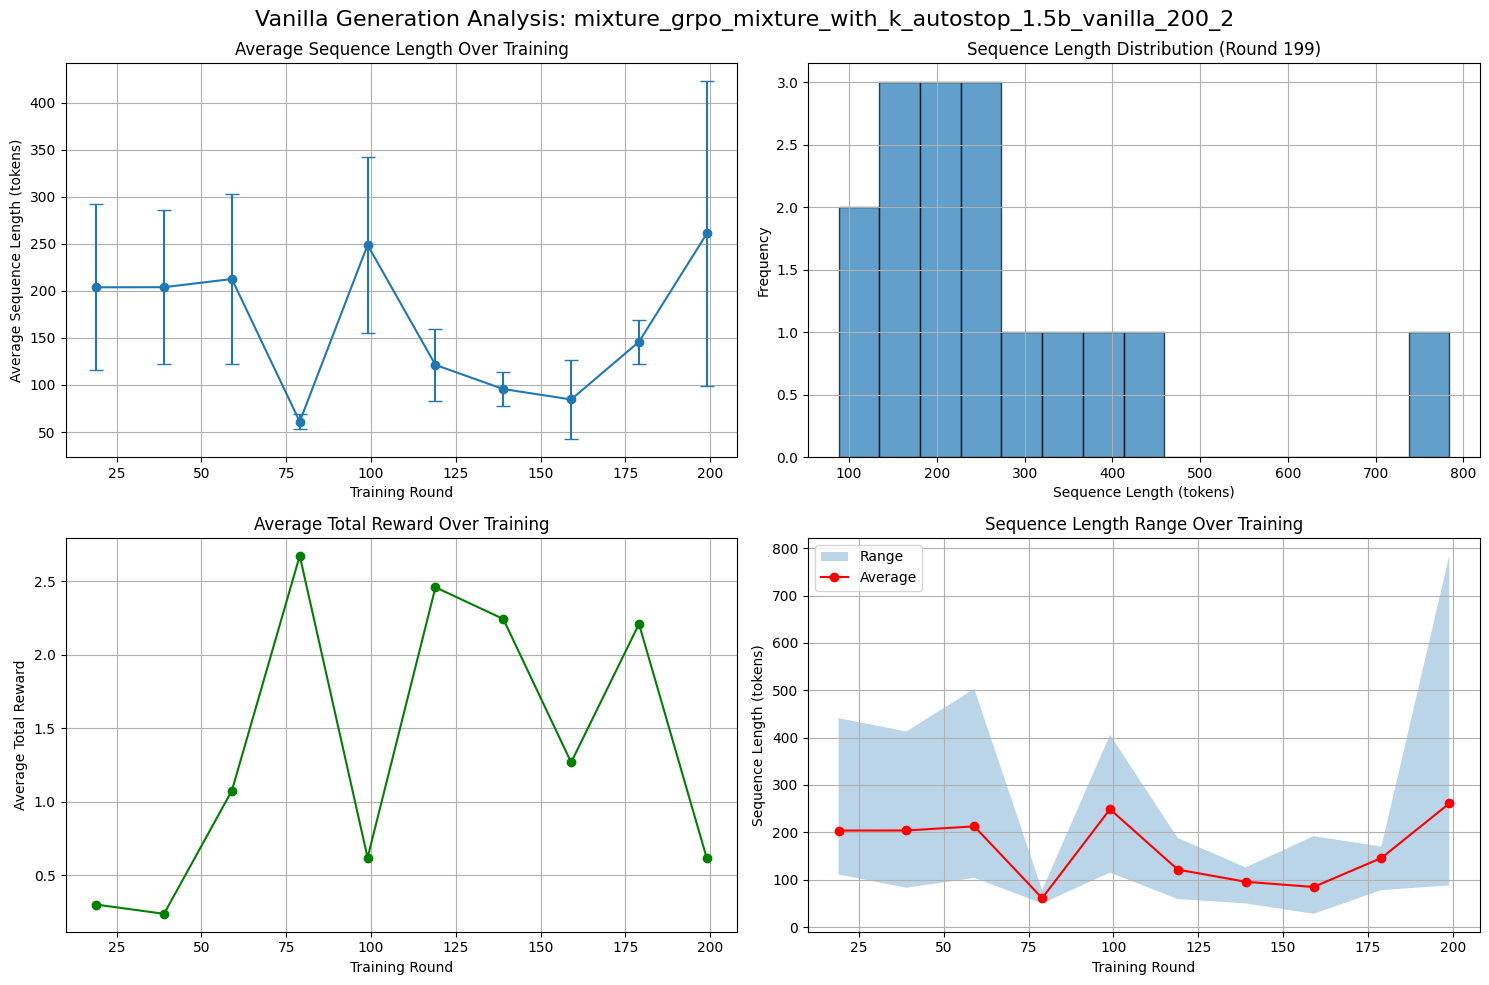


=== Summary Statistics for mixture_grpo_mixture_with_k_autostop_1.5b_vanilla_200_2 ===
Training rounds analyzed: 10
Average sequence length across all rounds: 163.9 ± 67.7
Latest round (199) average length: 261.0
Sequence length trend: Increasing
Average reward trend: Improving

=== Vanilla Generation Results Table ===
    avg_sequence_length std_sequence_length avg_total_reward num_generations
19             203.8125           88.411834         0.301687              16
39             203.9375           82.014838         0.238812              16
59              212.625           90.268956         1.076063              16
79              61.0625            7.821994          2.67225              16
99             248.8125           93.705802         0.620437              16
119            121.3125           38.402016         2.457938              16
139             95.6875           17.939895         2.242375              16
159              84.625            42.36283            1.268  

In [11]:
# === VANILLA GENERATION ANALYSIS ===
# Functions to analyze vanilla generation experiments (normal_generation=1)

import re
from transformers import AutoTokenizer

def load_vanilla_generation_file(experiment_name: str, round_num: int):
    """Load a vanilla generation .txt file for a specific training round."""
    exp_path = f"../GRPO_based_soft_thinking/output/{experiment_name}/training_logs"
    filepath = os.path.join(exp_path, f"{round_num}_generations.txt")
    
    if os.path.exists(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return f.read()
    else:
        print(f"File not found: {filepath}")
        return None

def parse_vanilla_generations(file_content: str):
    """Parse vanilla generation file to extract responses and metadata."""
    if not file_content:
        return None
    
    # Extract the prompt
    prompt_match = re.search(r'###### ORIGINAL PROMPT #####\n\n(.*?)\n\n#### ANS ####', file_content, re.DOTALL)
    prompt = prompt_match.group(1).strip() if prompt_match else ""
    
    # Extract the ground truth answer
    answer_match = re.search(r'#### ANS ####\n\n(.*?)\n#### GENERATION', file_content, re.DOTALL)
    ground_truth = answer_match.group(1).strip() if answer_match else ""
    
    # Extract all generations
    generation_pattern = r'#### GENERATION (\d+) RESPONSE ####\n\n(.*?)\n\n#### GENERATION \d+ SCORES ####'
    generations = re.findall(generation_pattern, file_content, re.DOTALL)
    
    # Extract scores for each generation
    scores_pattern = r'#### GENERATION (\d+) SCORES ####\n(.*?)\n(?=#### GENERATION|\Z)'
    scores_matches = re.findall(scores_pattern, file_content, re.DOTALL)
    
    parsed_data = {
        'prompt': prompt,
        'ground_truth': ground_truth,
        'generations': []
    }
    
    for gen_num, response in generations:
        # Find corresponding scores
        scores_dict = {}
        for score_num, scores_text in scores_matches:
            if score_num == gen_num:
                # Parse individual scores
                score_lines = scores_text.strip().split('\n')
                for line in score_lines:
                    if ':' in line:
                        key, value = line.split(':', 1)
                        try:
                            scores_dict[key.strip()] = float(value.strip())
                        except ValueError:
                            scores_dict[key.strip()] = value.strip()
                break
        
        parsed_data['generations'].append({
            'generation_num': int(gen_num),
            'response': response.strip(),
            'scores': scores_dict
        })
    
    return parsed_data

def analyze_vanilla_sequence_lengths(experiment_name: str, round_nums: list, tokenizer_name: str = "Qwen/Qwen2.5-1.5B-Instruct"):
    """Analyze sequence lengths across multiple training rounds for vanilla generation."""
    
    # Load tokenizer for accurate token counting
    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    except:
        print("Could not load tokenizer, using character-based length approximation")
        tokenizer = None
    
    results = {}
    
    for round_num in round_nums:
        print(f"Analyzing round {round_num}...")
        
        file_content = load_vanilla_generation_file(experiment_name, round_num)
        if not file_content:
            continue
            
        parsed_data = parse_vanilla_generations(file_content)
        if not parsed_data:
            continue
        
        # Calculate sequence lengths
        sequence_lengths = []
        total_rewards = []
        
        for gen in parsed_data['generations']:
            response = gen['response']
            
            # Calculate token length
            if tokenizer:
                try:
                    tokens = tokenizer.encode(response, add_special_tokens=False)
                    seq_length = len(tokens)
                except:
                    seq_length = len(response.split())  # Fallback to word count
            else:
                seq_length = len(response.split())  # Word count approximation
            
            sequence_lengths.append(seq_length)
            total_rewards.append(gen['scores'].get('Total reward', 0))
        
        results[round_num] = {
            'avg_sequence_length': np.mean(sequence_lengths),
            'std_sequence_length': np.std(sequence_lengths),
            'min_sequence_length': np.min(sequence_lengths),
            'max_sequence_length': np.max(sequence_lengths),
            'sequence_lengths': sequence_lengths,
            'avg_total_reward': np.mean(total_rewards) if total_rewards else 0,
            'num_generations': len(sequence_lengths),
            'prompt': parsed_data['prompt'][:100] + "..." if len(parsed_data['prompt']) > 100 else parsed_data['prompt']
        }
    
    return results

def plot_vanilla_sequence_analysis(results: dict, experiment_name: str):
    """Create visualizations for vanilla generation sequence length analysis."""
    
    if not results:
        print("No results to plot")
        return
    
    rounds = sorted(results.keys())
    avg_lengths = [results[r]['avg_sequence_length'] for r in rounds]
    std_lengths = [results[r]['std_sequence_length'] for r in rounds]
    avg_rewards = [results[r]['avg_total_reward'] for r in rounds]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Vanilla Generation Analysis: {experiment_name}', fontsize=16)
    
    # Plot 1: Average sequence length over training rounds
    axes[0, 0].errorbar(rounds, avg_lengths, yerr=std_lengths, marker='o', capsize=5)
    axes[0, 0].set_title('Average Sequence Length Over Training')
    axes[0, 0].set_xlabel('Training Round')
    axes[0, 0].set_ylabel('Average Sequence Length (tokens)')
    axes[0, 0].grid(True)
    
    # Plot 2: Sequence length distribution for latest round
    latest_round = max(rounds)
    latest_lengths = results[latest_round]['sequence_lengths']
    axes[0, 1].hist(latest_lengths, bins=15, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title(f'Sequence Length Distribution (Round {latest_round})')
    axes[0, 1].set_xlabel('Sequence Length (tokens)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True)
    
    # Plot 3: Average reward over training rounds
    axes[1, 0].plot(rounds, avg_rewards, marker='o', color='green')
    axes[1, 0].set_title('Average Total Reward Over Training')
    axes[1, 0].set_xlabel('Training Round')
    axes[1, 0].set_ylabel('Average Total Reward')
    axes[1, 0].grid(True)
    
    # Plot 4: Relationship between sequence length and reward (latest round)
    latest_rewards = [gen['scores'].get('Total reward', 0) for gen in 
                     [{'scores': {'Total reward': r}} for r in 
                      [0] * len(latest_lengths)]]  # Placeholder - we'd need to extract actual rewards
    
    # Instead, let's show min/max sequence lengths over time
    min_lengths = [results[r]['min_sequence_length'] for r in rounds]
    max_lengths = [results[r]['max_sequence_length'] for r in rounds]
    
    axes[1, 1].fill_between(rounds, min_lengths, max_lengths, alpha=0.3, label='Range')
    axes[1, 1].plot(rounds, avg_lengths, marker='o', color='red', label='Average')
    axes[1, 1].set_title('Sequence Length Range Over Training')
    axes[1, 1].set_xlabel('Training Round')
    axes[1, 1].set_ylabel('Sequence Length (tokens)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Summary Statistics for {experiment_name} ===")
    print(f"Training rounds analyzed: {len(rounds)}")
    print(f"Average sequence length across all rounds: {np.mean(avg_lengths):.1f} ± {np.std(avg_lengths):.1f}")
    print(f"Latest round ({latest_round}) average length: {avg_lengths[-1]:.1f}")
    print(f"Sequence length trend: {'Increasing' if avg_lengths[-1] > avg_lengths[0] else 'Decreasing'}")
    print(f"Average reward trend: {'Improving' if avg_rewards[-1] > avg_rewards[0] else 'Declining'}")

# Example analysis for vanilla experiment
vanilla_experiment = "mixture_grpo_mixture_with_k_autostop_1.5b_vanilla_200_2"
vanilla_rounds = [19, 39, 59, 79, 99, 119, 139, 159, 179, 199]  # Every 20 rounds

print("=== ANALYZING VANILLA GENERATION EXPERIMENT ===")
print(f"Experiment: {vanilla_experiment}")
print(f"Analyzing rounds: {vanilla_rounds}")

vanilla_results = analyze_vanilla_sequence_lengths(vanilla_experiment, vanilla_rounds)

if vanilla_results:
    plot_vanilla_sequence_analysis(vanilla_results, vanilla_experiment)
    
    # Create a DataFrame for easy comparison
    vanilla_df = pd.DataFrame(vanilla_results).T
    print("\n=== Vanilla Generation Results Table ===")
    print(vanilla_df[['avg_sequence_length', 'std_sequence_length', 'avg_total_reward', 'num_generations']].round(2))
else:
    print("No results obtained. Check file paths and experiment name.")


In [ ]:
def extract_detailed_token_data(gen_data: Dict[str, Any]) -> Dict[str, Any]:
    """
    Extract detailed token information for each round and chain.
    
    Returns:
        Dictionary with structure:
        {
            'round_num': int,
            'chains': {
                chain_id: {
                    'tokens': [list of token texts],
                    'token_ids': [list of token IDs],
                    'mixture_data': [
                        {
                            'step': int,
                            'is_mixture_phase': bool,
                            'selected_token': str,
                            'selected_token_id': int,
                            'top_k_tokens': [list of candidate token texts],
                            'top_k_token_ids': [list of candidate token IDs],
                            'top_k_probs': [list of original probabilities],
                            'mixture_weights': [list of mixture weights],
                            'representative_idx': int
                        }
                    ]
                }
            }
        }
    """
    if not gen_data:
        return None
    
    result = {
        'metadata': {
            'num_chains': gen_data.get('num_chains', 0),
            'temperature': gen_data.get('temperature', 0),
            'total_steps': len(gen_data.get('generation_steps', [])),
            'phase_transitions': gen_data.get('phase_transitions', [])
        },
        'chains': {}
    }
    
    # Initialize chain data
    num_chains = gen_data.get('num_chains', 0)
    for chain_id in range(num_chains):
        result['chains'][chain_id] = {
            'tokens': [],
            'token_ids': [],
            'mixture_data': []
        }
    
    # Process each generation step
    generation_steps = gen_data.get('generation_steps', [])
    
    for step_data in generation_steps:
        step_num = step_data['step']
        chains_data = step_data['chains']
        
        for chain_data in chains_data:
            chain_id = chain_data['chain_id']
            is_running = chain_data.get('is_running', False)
            
            if is_running:
                # Extract token information
                selected_token_text = chain_data.get('selected_token_text', '')
                selected_token_id = chain_data.get('selected_token_id', None)
                is_mixture_phase = chain_data.get('is_mixture_phase', False)
                
                # Add token to chain's token list
                result['chains'][chain_id]['tokens'].append(selected_token_text)
                result['chains'][chain_id]['token_ids'].append(selected_token_id)
                
                # Extract mixture-specific data
                mixture_step_data = {
                    'step': step_num,
                    'is_mixture_phase': is_mixture_phase,
                    'selected_token': selected_token_text,
                    'selected_token_id': selected_token_id
                }
                
                if is_mixture_phase:
                    mixture_step_data.update({
                        'top_k_tokens': chain_data.get('top_k_token_texts', []),
                        'top_k_token_ids': chain_data.get('top_k_token_ids', []),
                        'top_k_probs': chain_data.get('top_k_probs', []),
                        'mixture_weights': chain_data.get('normalized_mixture_weights', []),
                        'representative_idx': chain_data.get('representative_idx', 0)
                    })
                else:
                    # Normal sampling - no mixture data
                    mixture_step_data.update({
                        'sampled_prob': chain_data.get('sampled_prob', 0.0)
                    })
                
                result['chains'][chain_id]['mixture_data'].append(mixture_step_data)
    
    return result

def get_tokens_and_weights_for_round(round_num: int, base_path_override: str = None) -> Dict[str, Any]:
    """
    Get detailed token and weight information for a specific training round.
    
    Args:
        round_num: Training round number
        base_path_override: Optional override for base path
        
    Returns:
        Dictionary with token and weight information for all chains
    """
    global base_path
    original_base_path = base_path
    
    if base_path_override:
        base_path = base_path_override
    
    try:
        gen_data = load_detailed_generation(round_num)
        if gen_data:
            return extract_detailed_token_data(gen_data)
        else:
            return None
    finally:
        base_path = original_base_path

def summarize_token_analysis(token_data: Dict[str, Any]) -> None:
    """Print a summary of the token analysis."""
    if not token_data:
        print("No token data available")
        return
    
    print(f"=== Token Analysis Summary ===")
    print(f"Number of chains: {token_data['metadata']['num_chains']}")
    print(f"Total generation steps: {token_data['metadata']['total_steps']}")
    print(f"Temperature: {token_data['metadata']['temperature']}")
    print(f"Phase transitions: {len(token_data['metadata']['phase_transitions'])}")
    
    # Analyze each chain
    for chain_id, chain_data in token_data['chains'].items():
        print(f"\n--- Chain {chain_id} ---")
        print(f"Total tokens generated: {len(chain_data['tokens'])}")
        
        # Count mixture vs normal phases
        mixture_steps = sum(1 for step in chain_data['mixture_data'] if step['is_mixture_phase'])
        normal_steps = len(chain_data['mixture_data']) - mixture_steps
        
        print(f"Mixture phase steps: {mixture_steps}")
        print(f"Normal phase steps: {normal_steps}")
        
        # Show first few tokens
        first_tokens = chain_data['tokens'][:5]
        print(f"First 5 tokens: {first_tokens}")
        
        # Show generated text
        full_text = ''.join(chain_data['tokens'])
        print(f"Generated text: {full_text[:100]}{'...' if len(full_text) > 100 else ''}")

def analyze_mixture_weights_distribution(token_data: Dict[str, Any]) -> Dict[str, Any]:
    """Analyze the distribution of mixture weights across all chains and steps."""
    if not token_data:
        return None
    
    weight_analysis = {
        'weight_ratios': [],  # ratio of 2nd weight to 1st weight
        'weight_entropy': [],  # entropy of weight distribution
        'top_token_dominance': [],  # how often the top token is selected
        'token_diversity': []  # diversity of selected tokens
    }
    
    all_selected_tokens = []
    
    for chain_id, chain_data in token_data['chains'].items():
        for step_data in chain_data['mixture_data']:
            if step_data['is_mixture_phase']:
                mixture_weights = step_data.get('mixture_weights', [])
                top_k_tokens = step_data.get('top_k_tokens', [])
                representative_idx = step_data.get('representative_idx', 0)
                selected_token = step_data.get('selected_token', '')
                
                all_selected_tokens.append(selected_token)
                
                # Calculate weight ratio
                if len(mixture_weights) >= 2:
                    weight_ratio = mixture_weights[1] / mixture_weights[0] if mixture_weights[0] > 0 else 0
                    weight_analysis['weight_ratios'].append(weight_ratio)
                    
                    # Calculate entropy
                    weights = np.array(mixture_weights)
                    if weights.sum() > 0:
                        weights = weights / weights.sum()
                        entropy = -np.sum(weights * np.log(weights + 1e-10))
                        weight_analysis['weight_entropy'].append(entropy)
                
                # Check if top token was selected
                weight_analysis['top_token_dominance'].append(1 if representative_idx == 0 else 0)
    
    # Calculate token diversity
    if all_selected_tokens:
        unique_tokens = len(set(all_selected_tokens))
        total_tokens = len(all_selected_tokens)
        weight_analysis['token_diversity'] = unique_tokens / total_tokens
    
    return weight_analysis

# Example usage
print("=== DETAILED TOKEN EXTRACTION ===")

# Extract token data for a specific round
round_to_analyze = 175
print(f"Extracting detailed token data for round {round_to_analyze}...")

token_data = get_tokens_and_weights_for_round(round_to_analyze)

if token_data:
    # Print summary
    summarize_token_analysis(token_data)
    
    # Analyze mixture weights
    print("\n=== MIXTURE WEIGHTS ANALYSIS ===")
    weight_analysis = analyze_mixture_weights_distribution(token_data)
    
    if weight_analysis:
        print(f"Average weight ratio (2nd/1st): {np.mean(weight_analysis['weight_ratios']):.4f}")
        print(f"Average weight entropy: {np.mean(weight_analysis['weight_entropy']):.4f}")
        print(f"Top token dominance: {np.mean(weight_analysis['top_token_dominance']):.3f}")
        print(f"Token diversity: {weight_analysis['token_diversity']:.3f}")
    
    # Show detailed data for first chain (first few steps)
    print(f"\n=== DETAILED VIEW: Chain 0 (First 5 Steps) ===")
    chain_0_data = token_data['chains'][0]['mixture_data'][:5]
    
    for i, step_data in enumerate(chain_0_data):
        print(f"\nStep {step_data['step']}:")
        print(f"  Selected token: '{step_data['selected_token']}' (ID: {step_data['selected_token_id']})")
        print(f"  Mixture phase: {step_data['is_mixture_phase']}")
        
        if step_data['is_mixture_phase']:
            print(f"  Top-k tokens: {step_data.get('top_k_tokens', [])}")
            print(f"  Top-k probs: {[f'{p:.4f}' for p in step_data.get('top_k_probs', [])]}")
            print(f"  Mixture weights: {[f'{w:.4f}' for w in step_data.get('mixture_weights', [])]}")
            print(f"  Representative idx: {step_data.get('representative_idx', 0)}")
else:
    print("Could not extract token data. Check round number and file paths.")

print(f"\n=== AVAILABLE FUNCTIONS ===")
print("• extract_detailed_token_data(gen_data) - Extract tokens and weights from generation data")
print("• get_tokens_and_weights_for_round(round_num) - Get token data for specific round")
print("• summarize_token_analysis(token_data) - Print summary of token analysis")
print("• analyze_mixture_weights_distribution(token_data) - Analyze mixture weight patterns")


In [ ]:
# === SIMPLE TOKEN AND WEIGHTS EXTRACTION ===
# Simple function that returns just the tokens and weights as requested

def get_simple_tokens_and_weights(round_num: int, base_path_override: str = None) -> Dict[str, List]:
    """
    Simple function that returns a list of tokens for each chain and their mixture weights.
    
    Args:
        round_num: Training round number
        base_path_override: Optional override for base path
        
    Returns:
        Dictionary with structure:
        {
            'chain_0': {
                'tokens': ['<', 'reasoning', '>', ...],  # List of token texts
                'mixture_weights': [
                    [0.992, 0.008],  # Weights for mixture tokens (empty list for normal tokens)
                    [],              # Empty for normal phase tokens
                    [0.995, 0.005],  # Weights for mixture tokens
                    ...
                ]
            },
            'chain_1': { ... },
            ...
        }
    """
    token_data = get_tokens_and_weights_for_round(round_num, base_path_override)
    
    if not token_data:
        return None
    
    simple_result = {}
    
    for chain_id, chain_data in token_data['chains'].items():
        simple_result[f'chain_{chain_id}'] = {
            'tokens': chain_data['tokens'],  # List of token texts
            'mixture_weights': []
        }
        
        # Extract mixture weights for each step
        for step_data in chain_data['mixture_data']:
            if step_data['is_mixture_phase']:
                weights = step_data.get('mixture_weights', [])
                simple_result[f'chain_{chain_id}']['mixture_weights'].append(weights)
            else:
                # Normal phase - no mixture weights
                simple_result[f'chain_{chain_id}']['mixture_weights'].append([])
    
    return simple_result

def print_simple_tokens_sample(simple_data: Dict[str, List], num_chains: int = 2, num_tokens: int = 10):
    """Print a sample of the simple token and weights data."""
    if not simple_data:
        print("No data available")
        return
    
    print("=== SIMPLE TOKEN AND WEIGHTS SAMPLE ===")
    
    chain_keys = list(simple_data.keys())[:num_chains]
    
    for chain_key in chain_keys:
        chain_data = simple_data[chain_key]
        print(f"\n{chain_key.upper()}:")
        
        tokens = chain_data['tokens'][:num_tokens]
        weights = chain_data['mixture_weights'][:num_tokens]
        
        print("Tokens:", tokens)
        print("Weights:")
        
        for i, (token, weight) in enumerate(zip(tokens, weights)):
            if weight:  # Has mixture weights
                weight_str = [f"{w:.3f}" for w in weight]
                print(f"  Step {i}: '{token}' -> weights: {weight_str}")
            else:  # Normal sampling
                print(f"  Step {i}: '{token}' -> normal sampling")

# Example usage of simple extraction
print("=== SIMPLE TOKEN EXTRACTION EXAMPLE ===")

simple_tokens = get_simple_tokens_and_weights(175)

if simple_tokens:
    print_simple_tokens_sample(simple_tokens, num_chains=2, num_tokens=8)
    
    # Show full token sequence for one chain
    print(f"\n=== FULL TOKEN SEQUENCE (Chain 0) ===")
    chain_0_tokens = simple_tokens['chain_0']['tokens']
    full_text = ''.join(chain_0_tokens)
    print(f"Generated text: {full_text}")
    
    print(f"\nTotal tokens in chain 0: {len(chain_0_tokens)}")
    print(f"Number of chains: {len(simple_tokens)}")
else:
    print("Could not extract simple token data")

print(f"\n=== NEW SIMPLE FUNCTIONS ===")
print("• get_simple_tokens_and_weights(round_num) - Get simple token list and weights")
print("• print_simple_tokens_sample(simple_data) - Print sample of token data")


In [19]:
def extract_tokens_and_weights(round_num: int):
    """
    Extract tokens and weights for each chain in a training round.
    
    Returns:
        dict: {
            'round': int,
            'chains': {
                chain_id: {
                    'tokens': [list of selected token texts],
                    'mixture_weights': [list of weights for mixture tokens, None for normal tokens],
                    'is_mixture_phase': [list of booleans indicating if token was generated in mixture phase],
                    'top_k_options': [list of top-k token options for mixture tokens, None for normal]
                }
            }
        }
    """
    print(f"Loading round {round_num}...")
    gen_data = load_detailed_generation(round_num)
    
    if not gen_data:
        return None
    
    result = {
        'round': round_num,
        'chains': {}
    }
    
    # Initialize chain data
    num_chains = gen_data.get('num_chains', 16)
    for chain_id in range(num_chains):
        result['chains'][chain_id] = {
            'tokens': [],
            'mixture_weights': [],
            'is_mixture_phase': [],
            'top_k_options': []
        }
    
    # Process each generation step
    generation_steps = gen_data.get('generation_steps', [])
    
    for step_data in generation_steps:
        chains = step_data.get('chains', [])
        
        for chain in chains:
            chain_id = chain.get('chain_id')
            if chain_id is None or not chain.get('is_running', False):
                continue
                
            # Get basic token info
            selected_token_text = chain.get('selected_token_text', '')
            is_mixture = chain.get('is_mixture_phase', False)
            
            # Add token to chain
            result['chains'][chain_id]['tokens'].append(selected_token_text)
            result['chains'][chain_id]['is_mixture_phase'].append(is_mixture)
            
            if is_mixture:
                # Get mixture weights and top-k options
                mixture_weights = chain.get('normalized_mixture_weights', [])
                top_k_texts = chain.get('top_k_token_texts', [])
                top_k_probs = chain.get('top_k_probs', [])
                
                # Create top-k options with probabilities
                top_k_info = []
                for i, (token_text, prob) in enumerate(zip(top_k_texts, top_k_probs)):
                    weight = mixture_weights[i] if i < len(mixture_weights) else 0
                    top_k_info.append({
                        'token': token_text,
                        'original_prob': prob,
                        'mixture_weight': weight
                    })
                
                result['chains'][chain_id]['mixture_weights'].append(mixture_weights)
                result['chains'][chain_id]['top_k_options'].append(top_k_info)
                
            else:
                # Normal generation - no mixture info
                result['chains'][chain_id]['mixture_weights'].append(None)
                result['chains'][chain_id]['top_k_options'].append(None)
    
    return result

def extract_multiple_rounds(round_nums: list):
    """Extract tokens and weights for multiple training rounds."""
    all_rounds = {}
    
    for round_num in round_nums:
        round_data = extract_tokens_and_weights(round_num)
        if round_data:
            all_rounds[round_num] = round_data
    
    return all_rounds

def print_tokens_summary(round_data: dict, chain_id: int = 0, max_tokens: int = 20):
    """Print a readable summary of tokens for a specific chain."""
    if not round_data or chain_id not in round_data['chains']:
        print("No data available")
        return
    
    chain_data = round_data['chains'][chain_id]
    tokens = chain_data['tokens'][:max_tokens]
    mixture_phases = chain_data['is_mixture_phase'][:max_tokens]
    mixture_weights = chain_data['mixture_weights'][:max_tokens]
    top_k_options = chain_data['top_k_options'][:max_tokens]
    
    print(f"=== Round {round_data['round']}, Chain {chain_id} ===")
    print(f"Generated sequence (first {max_tokens} tokens):")
    print("'" + "".join(tokens) + "'")
    
    print(f"\nToken-by-token breakdown:")
    for i, (token, is_mixture) in enumerate(zip(tokens, mixture_phases)):
        if is_mixture and mixture_weights[i] is not None:
            weights = mixture_weights[i]
            top_k = top_k_options[i] if top_k_options[i] else []
            
            print(f"  {i:2d}: '{token}' [MIXTURE]")
            for j, option in enumerate(top_k[:3]):  # Show top-3 options
                marker = "→" if option['token'] == token else " "
                print(f"      {marker} '{option['token']}' (prob: {option['original_prob']:.3f}, weight: {option['mixture_weight']:.3f})")
        else:
            print(f"  {i:2d}: '{token}' [NORMAL]")

# Example usage
print("=== TOKEN AND WEIGHTS EXTRACTION ===")

# Extract data for a single round
round_180_data = extract_tokens_and_weights(180)

if round_180_data:
    print(f"Successfully loaded round 180 with {len(round_180_data['chains'])} chains")
    
    # Print summary for first chain
    print_tokens_summary(round_180_data, chain_id=0, max_tokens=15)
    
    # Print summary for another chain to see differences
    print("\n" + "="*50)
    print_tokens_summary(round_180_data, chain_id=1, max_tokens=15)

# Example: Extract multiple rounds
sample_rounds = [175, 180, 185]
print(f"\n=== EXTRACTING MULTIPLE ROUNDS: {sample_rounds} ===")
multi_round_data = extract_multiple_rounds(sample_rounds)

for round_num in sample_rounds:
    if round_num in multi_round_data:
        round_data = multi_round_data[round_num]
        total_tokens = len(round_data['chains'][0]['tokens']) if 0 in round_data['chains'] else 0
        mixture_tokens = sum(1 for is_mix in round_data['chains'][0]['is_mixture_phase'] if is_mix) if 0 in round_data['chains'] else 0
        print(f"Round {round_num}: {total_tokens} total tokens, {mixture_tokens} mixture tokens")

print("\n" + "="*60)
print("FUNCTIONS AVAILABLE:")
print("• extract_tokens_and_weights(round_num) - Get tokens & weights for one round")  
print("• extract_multiple_rounds(round_list) - Get data for multiple rounds")
print("• print_tokens_summary(round_data, chain_id, max_tokens) - Print readable summary")
print("="*60)


=== TOKEN AND WEIGHTS EXTRACTION ===
Loading round 180...
Successfully loaded round 180 with 16 chains
=== Round 180, Chain 0 ===
Generated sequence (first 15 tokens):
'<reasoning>
D's break the amount Derek money Derek has left step'

Token-by-token breakdown:
   0: '<' [MIXTURE]
      → '<' (prob: 0.980, weight: 0.992)
        'Let' (prob: 0.005, weight: 0.000)
   1: 'reason' [MIXTURE]
      → 'reason' (prob: 1.000, weight: 0.992)
        'answer' (prob: 0.000, weight: 0.000)
   2: 'ing' [MIXTURE]
      → 'ing' (prob: 1.000, weight: 0.992)
        '>
' (prob: 0.000, weight: 0.000)
   3: '>
' [MIXTURE]
      → '>
' (prob: 1.000, weight: 0.992)
        '>

' (prob: 0.001, weight: 0.000)
   4: 'D' [MIXTURE]
      → 'D' (prob: 0.479, weight: 0.391)
        'Let' (prob: 0.373, weight: 0.609)
   5: ''s' [MIXTURE]
      → ''s' (prob: 0.996, weight: 0.992)
        ' the' (prob: 0.001, weight: 0.000)
   6: ' break' [MIXTURE]
      → ' break' (prob: 0.688, weight: 0.428)
        ' calculate' (

In [6]:
# === VANILLA vs MIXTURE COMPARISON ===
# Compare sequence lengths between vanilla and mixture experiments

def compare_vanilla_vs_mixture(vanilla_experiment: str, mixture_experiment: str, 
                              vanilla_rounds: list, mixture_rounds: list):
    """Compare sequence lengths between vanilla and mixture experiments."""
    
    print("Loading vanilla experiment data...")
    vanilla_results = analyze_vanilla_sequence_lengths(vanilla_experiment, vanilla_rounds)
    
    print("Loading mixture experiment data...")
    mixture_results = {}
    for round_num in mixture_rounds:
        gen_data = load_detailed_generation(round_num)
        if gen_data:
            final_lengths = gen_data.get('final_sequences', {}).get('sequence_lengths', [])
            if final_lengths:
                mixture_results[round_num] = {
                    'avg_sequence_length': np.mean(final_lengths),
                    'std_sequence_length': np.std(final_lengths),
                    'sequence_lengths': final_lengths,
                    'num_generations': len(final_lengths)
                }
    
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Vanilla vs Mixture Generation Comparison', fontsize=16)
    
    # Extract data for plotting
    vanilla_rounds_data = sorted(vanilla_results.keys()) if vanilla_results else []
    mixture_rounds_data = sorted(mixture_results.keys()) if mixture_results else []
    
    if vanilla_rounds_data and mixture_rounds_data:
        vanilla_avg_lengths = [vanilla_results[r]['avg_sequence_length'] for r in vanilla_rounds_data]
        mixture_avg_lengths = [mixture_results[r]['avg_sequence_length'] for r in mixture_rounds_data]
        
        # Plot 1: Average sequence length comparison over training
        axes[0, 0].plot(vanilla_rounds_data, vanilla_avg_lengths, 'o-', label='Vanilla', color='blue')
        axes[0, 0].plot(mixture_rounds_data, mixture_avg_lengths, 's-', label='Mixture', color='red')
        axes[0, 0].set_title('Average Sequence Length Over Training')
        axes[0, 0].set_xlabel('Training Round')
        axes[0, 0].set_ylabel('Average Sequence Length (tokens)')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot 2: Sequence length distributions for latest rounds
        latest_vanilla_round = max(vanilla_rounds_data)
        latest_mixture_round = max(mixture_rounds_data)
        
        vanilla_latest_lengths = vanilla_results[latest_vanilla_round]['sequence_lengths']
        mixture_latest_lengths = mixture_results[latest_mixture_round]['sequence_lengths']
        
        axes[0, 1].hist(vanilla_latest_lengths, bins=15, alpha=0.6, label=f'Vanilla (Round {latest_vanilla_round})', color='blue')
        axes[0, 1].hist(mixture_latest_lengths, bins=15, alpha=0.6, label=f'Mixture (Round {latest_mixture_round})', color='red')
        axes[0, 1].set_title('Sequence Length Distributions (Latest Rounds)')
        axes[0, 1].set_xlabel('Sequence Length (tokens)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot 3: Standard deviation comparison
        vanilla_std_lengths = [vanilla_results[r]['std_sequence_length'] for r in vanilla_rounds_data]
        mixture_std_lengths = [mixture_results[r]['std_sequence_length'] for r in mixture_rounds_data]
        
        axes[1, 0].plot(vanilla_rounds_data, vanilla_std_lengths, 'o-', label='Vanilla', color='blue')
        axes[1, 0].plot(mixture_rounds_data, mixture_std_lengths, 's-', label='Mixture', color='red')
        axes[1, 0].set_title('Sequence Length Standard Deviation')
        axes[1, 0].set_xlabel('Training Round')
        axes[1, 0].set_ylabel('Standard Deviation (tokens)')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Plot 4: Box plot comparison for latest rounds
        box_data = [vanilla_latest_lengths, mixture_latest_lengths]
        box_labels = [f'Vanilla\n(Round {latest_vanilla_round})', f'Mixture\n(Round {latest_mixture_round})']
        
        axes[1, 1].boxplot(box_data, labels=box_labels)
        axes[1, 1].set_title('Sequence Length Box Plot Comparison')
        axes[1, 1].set_ylabel('Sequence Length (tokens)')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        from scipy import stats
        
        print("\n=== Statistical Comparison (Latest Rounds) ===")
        print(f"Vanilla (Round {latest_vanilla_round}):")
        print(f"  Mean: {np.mean(vanilla_latest_lengths):.1f} ± {np.std(vanilla_latest_lengths):.1f}")
        print(f"  Median: {np.median(vanilla_latest_lengths):.1f}")
        print(f"  Range: {np.min(vanilla_latest_lengths)} - {np.max(vanilla_latest_lengths)}")
        
        print(f"\nMixture (Round {latest_mixture_round}):")
        print(f"  Mean: {np.mean(mixture_latest_lengths):.1f} ± {np.std(mixture_latest_lengths):.1f}")
        print(f"  Median: {np.median(mixture_latest_lengths):.1f}")
        print(f"  Range: {np.min(mixture_latest_lengths)} - {np.max(mixture_latest_lengths)}")
        
        # Statistical test
        try:
            t_stat, p_value = stats.ttest_ind(vanilla_latest_lengths, mixture_latest_lengths)
            print(f"\nT-test results:")
            print(f"  t-statistic: {t_stat:.3f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
        except:
            print("\nCould not perform statistical test")
        
        # Overall trends
        vanilla_trend = "Increasing" if vanilla_avg_lengths[-1] > vanilla_avg_lengths[0] else "Decreasing"
        mixture_trend = "Increasing" if mixture_avg_lengths[-1] > mixture_avg_lengths[0] else "Decreasing"
        
        print(f"\n=== Training Trends ===")
        print(f"Vanilla sequence length trend: {vanilla_trend}")
        print(f"Mixture sequence length trend: {mixture_trend}")
        print(f"Average difference (Mixture - Vanilla): {np.mean(mixture_avg_lengths) - np.mean(vanilla_avg_lengths):.1f} tokens")
        
    else:
        print("Could not load both experiment types for comparison")

# Run the comparison
vanilla_exp = "mixture_grpo_vanilla_generation_1_1000steps"
mixture_exp_path = "../GRPO_based_soft_thinking/output/mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_8/training_logs"  # Use dirichlet experiment

# Set the base path for mixture experiment temporarily
original_base_path = base_path
base_path = mixture_exp_path

print("=== VANILLA vs MIXTURE COMPARISON ===")
compare_vanilla_vs_mixture(
    vanilla_experiment=vanilla_exp,
    mixture_experiment="mixture_grpo_mixture_with_k_autostop_1.5b_dirichlet_8",
    vanilla_rounds=range(400),
    mixture_rounds=range(400)
)

# Restore original base path
base_path = original_base_path

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nKey Analysis Functions Available:")
print("• load_vanilla_generation_file() - Load vanilla generation .txt files")
print("• parse_vanilla_generations() - Parse vanilla generation responses")  
print("• analyze_vanilla_sequence_lengths() - Analyze sequence lengths for vanilla")
print("• plot_vanilla_sequence_analysis() - Visualize vanilla generation analysis")
print("• compare_vanilla_vs_mixture() - Compare vanilla vs mixture experiments")
print("\nYou can now modify experiment names, rounds, and parameters to analyze different comparisons!")


=== VANILLA vs MIXTURE COMPARISON ===
Loading vanilla experiment data...


NameError: name 'analyze_vanilla_sequence_lengths' is not defined